# Hybrid WGAN-VQVAE Implementation

This notebook implements a sophisticated hybrid model combining **Vector Quantized VAE (VQVAE)** with **Wasserstein GAN (WGAN)** architectures. The implementation features:

## Key Features:
- **Dynamic Architecture**: Automatically scales with latent dimensions and input channels
- **Hybrid Training**: Combines VQVAE reconstruction with WGAN adversarial training
- **Robust Error Handling**: Proper dimensional handling and BatchNorm fixes
- **Professional Logging**: Structured logging with clear progress tracking
- **Visualization**: Real-time reconstruction quality assessment after each epoch
- **Multi-Dataset Support**: Works with MNIST, CIFAR10, and other image datasets

## Architecture Components:
1. **VQVAE Encoder/Decoder**: For learning discrete latent representations
2. **Vector Quantizer**: Codebook learning with commitment and codebook losses
3. **WGAN Critic**: Wasserstein distance estimation instead of binary classification
4. **Hybrid Loss**: Combines reconstruction, quantization, and adversarial losses
5. **Dynamic Scaling**: Architecture adapts to different input/latent dimensions

## Training Pipeline:
- Multi-step critic training with single generator step
- Gradient penalty for stable WGAN training
- Progressive visualization of reconstruction quality
- Comprehensive metrics tracking and logging


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import logging
from collections import defaultdict
import time
from IPython import display

# Set up comprehensive logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('hybrid_wgan_vqvae_training.log')
    ]
)

# Create main logger
logger = logging.getLogger('HybridVQVAE_WGAN')

# Set device globally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"HYBRID WGAN-VQVAE INITIALIZED")
logger.info(f"Device: {device}")

if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name()}")
    logger.info(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    logger.info("Running on CPU - training will be slower")

logger.info("="*80)


2025-08-10 23:32:00,098 - HybridVQVAE_WGAN - INFO - HYBRID WGAN-VQVAE INITIALIZED
2025-08-10 23:32:00,100 - HybridVQVAE_WGAN - INFO - Device: cuda
2025-08-10 23:32:00,250 - HybridVQVAE_WGAN - INFO - GPU: Quadro RTX 6000
2025-08-10 23:32:00,251 - HybridVQVAE_WGAN - INFO - GPU Memory: 23.8 GB
2025-08-10 23:32:00,252 - HybridVQVAE_WGAN - INFO - ================================================================================


In [8]:
class DataSetLoader:
    """Enhanced dataset loader with comprehensive logging and error handling"""
    
    def __init__(self, data_dir="./data", batch_size=64):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.logger = logging.getLogger(f'{__name__}.DataSetLoader')
        self.logger.info(f"DataSetLoader initialized | batch_size={batch_size} | data_dir={data_dir}")
        
    def load_mnist(self):
        """Load MNIST dataset with proper transforms"""
        self.logger.info("🔄 Loading MNIST dataset...")
        
        compose = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
        ])
        
        out_dir = f'{self.data_dir}/dataset'
        data = datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
        
        data_loader = DataLoader(data, batch_size=self.batch_size, shuffle=True, drop_last=True)
        num_batches = len(data_loader)
        img_size = [64, 64]
        channels = 1
        
        self.logger.info(f"MNIST loaded | Dataset=mnist | batches={num_batches} | img_size={img_size} | channels={channels}")
        return data_loader, num_batches, img_size, channels
    
    def load_cifar10(self):
        """Load CIFAR10 dataset with proper transforms"""
        self.logger.info("Loading CIFAR10 dataset...")
        
        compose = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
        ])
        
        out_dir = f'{self.data_dir}/dataset'
        data = datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)
        
        data_loader = DataLoader(data, batch_size=self.batch_size, shuffle=True, drop_last=True)
        num_batches = len(data_loader)
        img_size = [64, 64]
        channels = 3
        
        self.logger.info(f"CIFAR10 loaded | Dataset=cifar10 | batches={num_batches} | img_size={img_size} | channels={channels}")
        return data_loader, num_batches, img_size, channels

logger.info("DataSetLoader class created successfully!")


2025-08-10 23:35:10,903 - HybridVQVAE_WGAN - INFO - DataSetLoader class created successfully!


In [9]:
class VectorQuantizer(nn.Module):
    """Enhanced Vector Quantizer with proper initialization and logging"""
    
    def __init__(self, codebook_size, embedding_dim, commitment_cost=0.25):
        super().__init__()
        self.codebook_size = codebook_size
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        
        # Initialize embeddings with proper scaling
        self.embeddings = nn.Embedding(codebook_size, embedding_dim)
        self.embeddings.weight.data.uniform_(-1/codebook_size, 1/codebook_size)
        
        self.logger = logging.getLogger(f'{__name__}.VectorQuantizer')
        self.logger.info(f"VectorQuantizer | codebook_size={codebook_size} | embedding_dim={embedding_dim}")

    def forward(self, inputs):

        # Flatten spatial dimensions
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)
        
        # Calculate distances to codebook entries
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self.embeddings.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embeddings.weight.t()))
        
        # Find closest codebook entries
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.codebook_size, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embeddings.weight).view(input_shape)
        
        # Calculate losses
        codebook_loss = F.mse_loss(quantized.detach(), inputs)
        commitment_loss = F.mse_loss(quantized, inputs.detach())
        
        # Straight-through estimator
        quantized = inputs + (quantized - inputs).detach()
        
        return quantized, codebook_loss, commitment_loss

logger.info("VectorQuantizer class created successfully!")


2025-08-10 23:35:13,892 - HybridVQVAE_WGAN - INFO - VectorQuantizer class created successfully!


In [10]:
class VQVAE(nn.Module):
    
    def __init__(self, input_dim=3, latent_dim=128, codebook_size=1024, img_size=[64, 64]):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size
        self.img_size = img_size
        
        self.logger = logging.getLogger(f'{__name__}.VQVAE')
        
        # Dynamic channel scaling based on latent_dim
        base_channels = max(32, latent_dim // 4)  # Ensure minimum 32 channels
        
        # Encoder: progressively increase channels
        self.encoder = nn.Sequential(
            # First block: input_dim -> base_channels
            nn.Conv2d(input_dim, base_channels, 4, 2, 1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            
            # Second block: base_channels -> base_channels*2
            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(inplace=True),
            
            # Third block: base_channels*2 -> base_channels*4
            nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(inplace=True),
            
            # Fourth block: base_channels*4 -> latent_dim
            nn.Conv2d(base_channels*4, latent_dim, 4, 2, 1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(inplace=True),
        )
        
        # Vector Quantizer
        self.quantizer = VectorQuantizer(codebook_size, latent_dim)
        
        # Decoder: progressively decrease channels (reverse of encoder)
        self.decoder = nn.Sequential(
            # First block: latent_dim -> base_channels*4
            nn.ConvTranspose2d(latent_dim, base_channels*4, 4, 2, 1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(inplace=True),
            
            # Second block: base_channels*4 -> base_channels*2
            nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, 2, 1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(inplace=True),
            
            # Third block: base_channels*2 -> base_channels
            nn.ConvTranspose2d(base_channels*2, base_channels, 4, 2, 1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            
            # Final block: base_channels -> input_dim (no BatchNorm on output)
            nn.ConvTranspose2d(base_channels, input_dim, 4, 2, 1),
            nn.Tanh()  # Output in [-1, 1] range
        )
        
        # Apply proper weight initialization
        self.apply(self._init_weights)
        
        self.logger.info(f"DynamicVQVAE Architecture:")
        self.logger.info(f"   Input: {input_dim} channels, {img_size}")
        self.logger.info(f"   Latent: {latent_dim} dimensions")
        self.logger.info(f"   Codebook: {codebook_size} entries")
        self.logger.info(f"   Base channels: {base_channels}")
        self.logger.info(f"   Total params: {sum(p.numel() for p in self.parameters()):,}")
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        if x.dim() != 4:
            raise ValueError(f"Expected 4D input [B,C,H,W], got {x.dim()}D input with shape {x.shape}")
        z_e = self.encode(x)
        
        z_q, codebook_loss, commitment_loss = self.quantizer(z_e)
        
        x_recon = self.decode(z_q)
        
        return {
            'reconstructed': x_recon,
            'codebook_loss': codebook_loss,
            'commitment_loss': commitment_loss,
            'latent_encoded': z_e,
            'latent_quantized': z_q
        }

logger.info("DynamicVQVAE class created successfully!")


2025-08-10 23:35:16,601 - HybridVQVAE_WGAN - INFO - DynamicVQVAE class created successfully!


In [11]:
class WGANCritic(nn.Module):
    
    def __init__(self, input_dim=3, latent_dim=128, img_size=[64, 64]):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.img_size = img_size
        
        self.logger = logging.getLogger(f'{__name__}.WGANCritic')
        
        # Dynamic channel scaling
        base_channels = max(32, latent_dim // 4)
        
        # Calculate final spatial dimensions
        self.final_height = img_size[0] // (2**4)  # 4 conv layers with stride 2
        self.final_width = img_size[1] // (2**4)
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1: input_dim -> base_channels
            nn.Conv2d(input_dim, base_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 2: base_channels -> base_channels*2
            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 3: base_channels*2 -> base_channels*4
            nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 4: base_channels*4 -> base_channels*8
            nn.Conv2d(base_channels*4, base_channels*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Final output layer (no sigmoid for WGAN)
        self.final_layer = nn.Sequential(
            nn.Conv2d(base_channels*8, 1, kernel_size=self.final_height, stride=1, padding=0, bias=False),
            nn.Flatten()
        )
        
        # Apply weight initialization
        self.apply(self._init_weights)
        
        self.logger.info(f"DynamicWGANCritic Architecture:")
        self.logger.info(f"   Input: {input_dim} channels, {img_size}")
        self.logger.info(f"   Base channels: {base_channels}")
        self.logger.info(f"   Final spatial: {self.final_height}x{self.final_width}")
        self.logger.info(f"   Total params: {sum(p.numel() for p in self.parameters()):,}")
    
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.final_layer(x)
        return x.squeeze()  # Return [B] scores
    
    def clip_weights(self, clip_value=0.01):
        for param in self.parameters():
            param.data.clamp_(-clip_value, clip_value)

logger.info("WGANCritic class created successfully!")


2025-08-10 23:35:20,143 - HybridVQVAE_WGAN - INFO - WGANCritic class created successfully!


In [12]:
class HybridVQVAEWGAN(nn.Module):
    
    def __init__(self, input_dim=3, latent_dim=128, codebook_size=1024, img_size=[64, 64]):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size
        self.img_size = img_size
        
        self.logger = logging.getLogger(f'{__name__}.HybridVQVAEWGAN')
        
        # VQVAE for reconstruction
        self.vqvae = VQVAE(input_dim, latent_dim, codebook_size, img_size)
        
        # WGAN Critic for adversarial training
        self.critic = WGANCritic(input_dim, latent_dim, img_size)
        
        self.logger.info(f"HybridVQVAEWGAN initialized:")
        self.logger.info(f"   Input dimensions: {input_dim}")
        self.logger.info(f"   Latent dimensions: {latent_dim}")
        self.logger.info(f"   Codebook size: {codebook_size}")
        self.logger.info(f"   Image size: {img_size}")
        
        total_params = sum(p.numel() for p in self.parameters())
        vqvae_params = sum(p.numel() for p in self.vqvae.parameters())
        critic_params = sum(p.numel() for p in self.critic.parameters())
        
        self.logger.info(f"   Total parameters: {total_params:,}")
        self.logger.info(f"   VQVAE parameters: {vqvae_params:,}")
        self.logger.info(f"   Critic parameters: {critic_params:,}")
    
    def forward(self, x):
        return self.vqvae(x)
    
    def reconstruct(self, x):
        with torch.no_grad():
            result = self.vqvae(x)
            return result['reconstructed']
    
    def encode(self, x):
        return self.vqvae.encode(x)
    
    def decode(self, z):
        return self.vqvae.decode(z)
    
    def critic_score(self, x):
        return self.critic(x)

logger.info("HybridVQVAEWGAN class created successfully!")


2025-08-10 23:35:23,135 - HybridVQVAE_WGAN - INFO - HybridVQVAEWGAN class created successfully!


In [ ]:
class HybridTrainer:
    
    def __init__(self, model, device, vqvae_lr=1e-3, critic_lr=5e-5, 
                 lambda_gp=10, critic_iters=5, loss_weights=None,
                 use_weight_clipping=False, clip_value=0.01):
        self.model = model.to(device)
        self.device = device
        self.critic_iters = critic_iters
        self.lambda_gp = lambda_gp
        
        # Weight clipping parameters
        self.use_weight_clipping = use_weight_clipping
        self.clip_value = clip_value
        
        # Loss weights
        if loss_weights is None:
            loss_weights = {'adversarial': 1.0, 'codebook': 1.0, 'commitment': 1.0}
        self.loss_weights = loss_weights
        
        # Optimizers RMSProp for WGAN and Adam for VQVAE
        self.vqvae_optimizer = optim.Adam(model.vqvae.parameters(), lr=vqvae_lr)
        self.critic_optimizer = optim.RMSprop(model.critic.parameters(), lr=critic_lr)
        
        # Training metrics
        self.history = defaultdict(list)
        
        self.logger = logging.getLogger(f'{__name__}.HybridTrainer')
        self.logger.info(f"Trainer initialized on {device}")
        self.logger.info(f"VQVAE learning rate: {vqvae_lr}")
        self.logger.info(f"Critic learning rate: {critic_lr}")
        self.logger.info(f"Loss weights: {loss_weights}")
        self.logger.info(f"Critic iterations per step: {critic_iters}")
        self.logger.info(f"Gradient penalty lambda: {lambda_gp}")
        if use_weight_clipping:
            self.logger.info(f"Using weight clipping with clip value: {clip_value}")
            if lambda_gp > 0:
                self.logger.warning("Both gradient penalty and weight clipping enabled - consider using only one!")
        else:
            self.logger.info("Weight clipping disabled - using gradient penalty")
    
    @torch.no_grad()
    def reconstruct_samples(self, x, num_samples=4):
        self.model.eval()
        x_sample = x[:num_samples].to(self.device)
        reconstructed = self.model.reconstruct(x_sample)
        self.model.train()
        return x_sample.cpu(), reconstructed.cpu()
    
    def clip_critic_weights(self):
        """Apply weight clipping to critic parameters for WGAN training"""
        if self.use_weight_clipping:
            for param in self.model.critic.parameters():
                param.data.clamp_(-self.clip_value, self.clip_value)
    
    def gradient_penalty(self, real_images, fake_images):
        batch_size = real_images.size(0)
        
        # Random interpolation weight
        alpha = torch.rand(batch_size, 1, 1, 1, device=self.device)
        
        # Interpolated images
        interpolated = alpha * real_images + (1 - alpha) * fake_images
        interpolated.requires_grad_(True)
        
        # Critic scores for interpolated images
        scores = self.model.critic(interpolated)
        
        # Calculate gradients
        gradients = torch.autograd.grad(
            outputs=scores,
            inputs=interpolated,
            grad_outputs=torch.ones_like(scores),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        # Gradient penalty
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        penalty = torch.mean((gradient_norm - 1) ** 2)
        
        return penalty
    
    def train_critic(self, real_images):
        batch_size = real_images.size(0)
        
        # Generate fake images from VQVAE reconstructions
        with torch.no_grad():
            vqvae_output = self.model.vqvae(real_images)
            fake_images = vqvae_output['reconstructed']
        
        # Reset gradients
        self.critic_optimizer.zero_grad()
        
        # Critic scores
        real_scores = self.model.critic(real_images)
        fake_scores = self.model.critic(fake_images.detach())
        
        # Wasserstein loss
        wasserstein_loss = torch.mean(fake_scores) - torch.mean(real_scores)
        
        # Gradient penalty
        gp = self.gradient_penalty(real_images, fake_images)
        
        # Total critic loss
        critic_loss = wasserstein_loss + self.lambda_gp * gp
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Apply weight clipping if enabled
        self.clip_critic_weights()
        
        return {
            'critic_loss': critic_loss.item(),
            'wasserstein_distance': -wasserstein_loss.item(),
            'gradient_penalty': gp.item(),
            'real_score': real_scores.mean().item(),
            'fake_score': fake_scores.mean().item()
        }
    
    def train_vqvae(self, real_images):
        # Reset gradients
        self.vqvae_optimizer.zero_grad()
        
        # VQVAE forward pass
        vqvae_output = self.model.vqvae(real_images)
        reconstructed = vqvae_output['reconstructed']
        codebook_loss = vqvae_output['codebook_loss']
        commitment_loss = vqvae_output['commitment_loss']
        
        # Reconstruction loss (MSE) -  Not used for now
        recon_loss = F.mse_loss(reconstructed, real_images)
        
        # Adversarial loss (fool the critic)
        critic_scores = self.model.critic(reconstructed)
        adversarial_loss = -torch.mean(critic_scores)
        
        # Combined loss
        total_loss = (recon_loss +
                     self.loss_weights['adversarial'] * adversarial_loss +
                     self.loss_weights['codebook'] * codebook_loss +
                     self.loss_weights['commitment'] * commitment_loss)
        
        total_loss.backward()
        self.vqvae_optimizer.step()
        
        return {
            'vqvae_total_loss': total_loss.item(),
            'reconstruction_loss': recon_loss.item(),
            'adversarial_loss': adversarial_loss.item(),
            'codebook_loss': codebook_loss.item(),
            'commitment_loss': commitment_loss.item()
        }
    
    def train_step(self, real_images):
        real_images = real_images.to(self.device)
        
        # Train critic multiple times
        critic_metrics = []
        for _ in range(self.critic_iters):
            critic_metrics.append(self.train_critic(real_images))
        
        # Average critic metrics
        avg_critic_metrics = {}
        for key in critic_metrics[0].keys():
            avg_critic_metrics[key] = np.mean([m[key] for m in critic_metrics])
        
        # Train VQVAE once
        vqvae_metrics = self.train_vqvae(real_images)
        
        # Combine metrics
        combined_metrics = {**avg_critic_metrics, **vqvae_metrics}
        
        return combined_metrics
    
    def visualize_reconstruction(self, dataloader, epoch, save_path=None):
        # Get a batch for visualization
        for batch in dataloader:
            real_images, _ = batch
            break
        
        original, reconstructed = self.reconstruct_samples(real_images, num_samples=4)
        
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        
        for i in range(4):
            # Original images
            if original.shape[1] == 1:  # Grayscale
                axes[0, i].imshow(original[i, 0], cmap='gray', vmin=-1, vmax=1)
            else:  # RGB
                img = original[i].permute(1, 2, 0)
                img = (img + 1) / 2  # Denormalize
                axes[0, i].imshow(torch.clamp(img, 0, 1))
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            # Reconstructed images
            if reconstructed.shape[1] == 1:  # Grayscale
                axes[1, i].imshow(reconstructed[i, 0], cmap='gray', vmin=-1, vmax=1)
            else:  # RGB
                img = reconstructed[i].permute(1, 2, 0)
                img = (img + 1) / 2  # Denormalize
                axes[1, i].imshow(torch.clamp(img, 0, 1))
            axes[1, i].set_title(f'Reconstructed {i+1}')
            axes[1, i].axis('off')
        
        plt.suptitle(f'Reconstruction Quality - Epoch {epoch}', fontsize=16)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}/epoch_{epoch}_reconstruction.png", dpi=150, bbox_inches='tight')
        
        plt.show()
    
    def train(self, dataloader, num_epochs=10, log_every=100, viz_every=1):
        self.logger.info("="*80)
        self.logger.info(f"STARTING HYBRID VQVAE-WGAN TRAINING")
        self.logger.info(f"Training for {num_epochs} epochs | {len(dataloader)} steps/epoch")
        self.logger.info("="*80)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            epoch_metrics = defaultdict(list)
            
            # Training loop
            for step, (real_images, _) in enumerate(dataloader):
                metrics = self.train_step(real_images)
                
                # Store metrics
                for key, value in metrics.items():
                    epoch_metrics[key].append(value)
                    self.history[key].append(value)
                
                # Periodic logging
                if step % log_every == 0:
                    self.logger.info(
                        f"Epoch {epoch} Step {step}: "
                        f"G_loss={metrics['vqvae_total_loss']:.4f} "
                        f"R_loss={metrics['reconstruction_loss']:.4f} "
                        f"Crit_loss={metrics['adversarial_loss']:.4f} "
                        f"CB_loss={metrics['codebook_loss']:.4f} "
                        f"CM_loss={metrics['commitment_loss']:.4f} "
                        f"GP_loss={metrics['gradient_penalty']:.4f} "
                        f"W_dist={metrics['wasserstein_distance']:.4f}"
                    )
            
            # End of epoch summary
            epoch_time = time.time() - epoch_start
            avg_metrics = {k: np.mean(v) for k, v in epoch_metrics.items()}
            
            self.logger.info("="*80)
            self.logger.info(f"EPOCH {epoch} COMPLETED in {epoch_time:.1f}s")
            self.logger.info(f"Generator_total_loss: {avg_metrics['vqvae_total_loss']:.4f}")
            self.logger.info(f"Reconstruction_loss: {avg_metrics['reconstruction_loss']:.4f}")
            self.logger.info(f"Adversarial_loss: {avg_metrics['adversarial_loss']:.4f}")
            self.logger.info(f"Codebook_loss: {avg_metrics['codebook_loss']:.4f}")
            self.logger.info(f"Commitment_loss: {avg_metrics['commitment_loss']:.4f}")
            self.logger.info(f"Wasserstein_distance: {avg_metrics['wasserstein_distance']:.4f}")
            self.logger.info("="*80)
            
            # Visualization
            if epoch % viz_every == 0:
                self.logger.info(f"Generating reconstruction visualization for epoch {epoch}...")
                self.visualize_reconstruction(dataloader, epoch)
        
        total_time = time.time() - start_time
        self.logger.info(f"TRAINING COMPLETED in {total_time/60:.1f} minutes!")
    
    def plot_history(self):
        if not self.history:
            self.logger.warning("No training history to plot")
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        axes = axes.flatten()
        
        metrics_to_plot = [
            'vqvae_total_loss', 'reconstruction_loss', 'adversarial_loss',
            'critic_loss', 'wasserstein_distance', 'codebook_loss'
        ]
        
        for i, metric in enumerate(metrics_to_plot):
            if metric in self.history:
                axes[i].plot(self.history[metric], alpha=0.7)
                axes[i].set_title(metric.replace('_', ' ').title())
                axes[i].set_xlabel('Step')
                axes[i].grid(True, alpha=0.3)
        
        plt.suptitle('🏋️‍♂️ Training History - Hybrid VQVAE-WGAN', fontsize=16)
        plt.tight_layout()
        plt.show()

logger.info("HybridTrainer class created successfully!")


2025-08-10 23:35:26,130 - HybridVQVAE_WGAN - INFO - HybridTrainer class created successfully!


2025-08-10 21:36:57,373 - HybridVQVAE_WGAN - INFO - PREPARING CIFAR10 TRAINING EXAMPLE
2025-08-10 21:36:57,375 - HybridVQVAE_WGAN - INFO - ================================================================================
2025-08-10 21:36:57,376 - __main__.DataSetLoader - INFO - DataSetLoader initialized | batch_size=64 | data_dir=./data
2025-08-10 21:36:57,377 - __main__.DataSetLoader - INFO - Loading CIFAR10 dataset...


Files already downloaded and verified


2025-08-10 21:36:58,395 - __main__.DataSetLoader - INFO - CIFAR10 loaded | Dataset=cifar10 | batches=781 | img_size=[64, 64] | channels=3
2025-08-10 21:36:58,431 - __main__.VectorQuantizer - INFO - VectorQuantizer | codebook_size=1024 | embedding_dim=128
2025-08-10 21:36:58,444 - __main__.VQVAE - INFO - DynamicVQVAE Architecture:
2025-08-10 21:36:58,444 - __main__.VQVAE - INFO -    Input: 3 channels, [64, 64]
2025-08-10 21:36:58,445 - __main__.VQVAE - INFO -    Latent: 128 dimensions
2025-08-10 21:36:58,446 - __main__.VQVAE - INFO -    Codebook: 1024 entries
2025-08-10 21:36:58,446 - __main__.VQVAE - INFO -    Base channels: 32
2025-08-10 21:36:58,447 - __main__.VQVAE - INFO -    Total params: 987,843
2025-08-10 21:36:58,460 - __main__.WGANCritic - INFO - DynamicWGANCritic Architecture:
2025-08-10 21:36:58,460 - __main__.WGANCritic - INFO -    Input: 3 channels, [64, 64]
2025-08-10 21:36:58,461 - __main__.WGANCritic - INFO -    Base channels: 32
2025-08-10 21:36:58,462 - __main__.WGANC

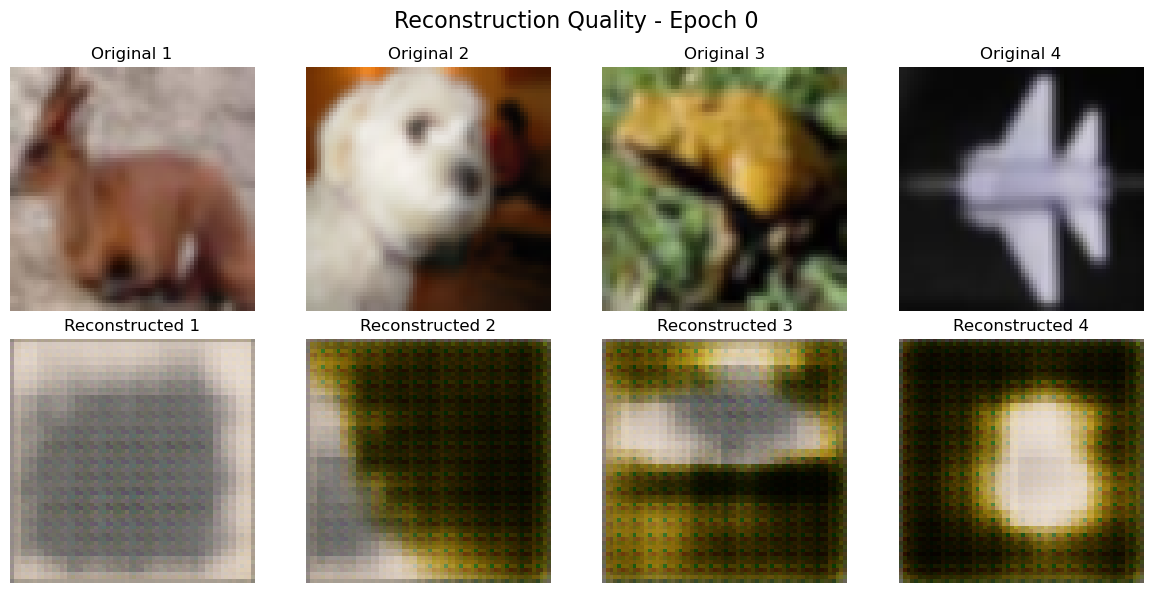

2025-08-10 21:39:46,024 - __main__.HybridTrainer - INFO - Epoch 1 Step 0: Generator_total_loss=32.4702 Reconstruction_loss=0.3630 Adversarial_loss=31.7561 Codebook_loss=0.3571 Commitment_loss=0.3571 W_dist=96.5816
2025-08-10 21:40:07,671 - __main__.HybridTrainer - INFO - Epoch 1 Step 100: Generator_total_loss=39.3571 Reconstruction_loss=0.5011 Adversarial_loss=38.7220 Codebook_loss=0.3176 Commitment_loss=0.3176 W_dist=49.4901
2025-08-10 21:40:28,937 - __main__.HybridTrainer - INFO - Epoch 1 Step 200: Generator_total_loss=39.8655 Reconstruction_loss=0.3291 Adversarial_loss=39.2135 Codebook_loss=0.3260 Commitment_loss=0.3260 W_dist=67.3202
2025-08-10 21:40:49,601 - __main__.HybridTrainer - INFO - Epoch 1 Step 300: Generator_total_loss=37.1763 Reconstruction_loss=0.4458 Adversarial_loss=36.5353 Codebook_loss=0.3205 Commitment_loss=0.3205 W_dist=58.9586
2025-08-10 21:41:11,271 - __main__.HybridTrainer - INFO - Epoch 1 Step 400: Generator_total_loss=39.6415 Reconstruction_loss=0.5011 Advers

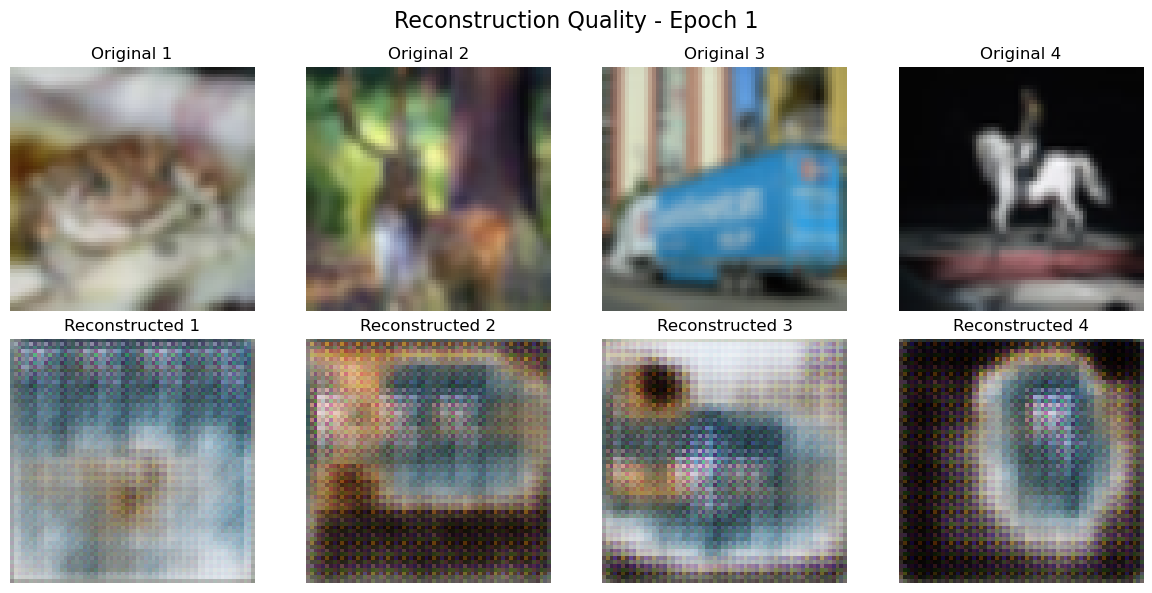

2025-08-10 21:42:31,539 - __main__.HybridTrainer - INFO - Epoch 2 Step 0: Generator_total_loss=30.8563 Reconstruction_loss=0.3467 Adversarial_loss=30.3563 Codebook_loss=0.2500 Commitment_loss=0.2500 W_dist=28.9997
2025-08-10 21:42:53,119 - __main__.HybridTrainer - INFO - Epoch 2 Step 100: Generator_total_loss=26.7983 Reconstruction_loss=0.2976 Adversarial_loss=26.3232 Codebook_loss=0.2375 Commitment_loss=0.2375 W_dist=24.2408
2025-08-10 21:43:13,633 - __main__.HybridTrainer - INFO - Epoch 2 Step 200: Generator_total_loss=21.2724 Reconstruction_loss=0.3429 Adversarial_loss=20.7505 Codebook_loss=0.2609 Commitment_loss=0.2609 W_dist=29.0643
2025-08-10 21:43:35,279 - __main__.HybridTrainer - INFO - Epoch 2 Step 300: Generator_total_loss=20.1431 Reconstruction_loss=0.3276 Adversarial_loss=19.6401 Codebook_loss=0.2515 Commitment_loss=0.2515 W_dist=21.2589
2025-08-10 21:43:56,855 - __main__.HybridTrainer - INFO - Epoch 2 Step 400: Generator_total_loss=15.9780 Reconstruction_loss=0.3607 Advers

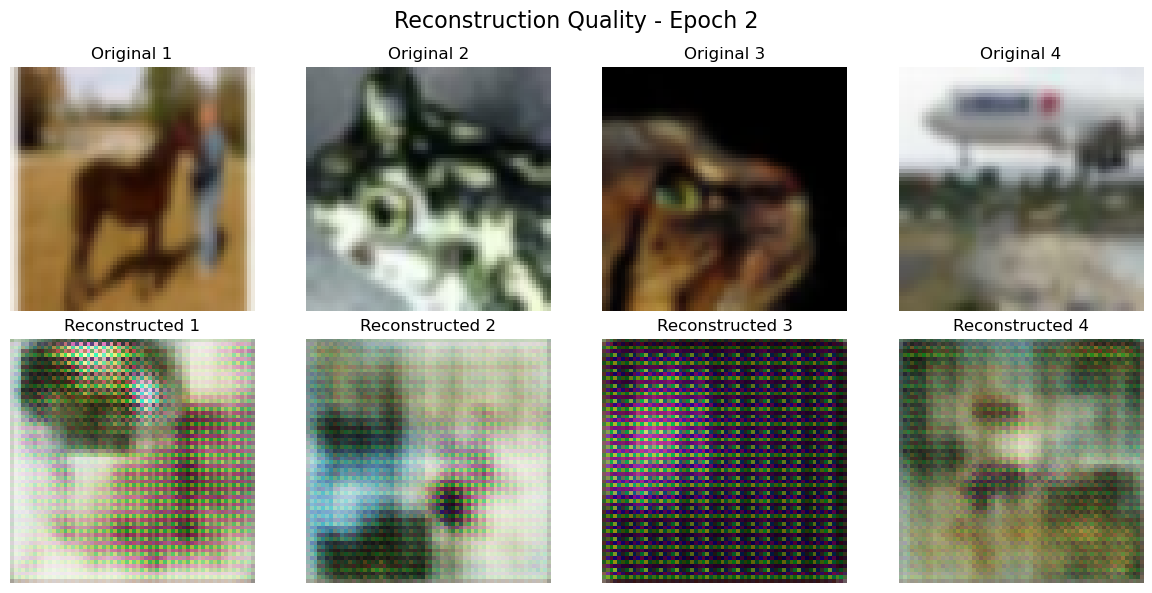

2025-08-10 21:45:17,424 - __main__.HybridTrainer - INFO - Epoch 3 Step 0: Generator_total_loss=9.5590 Reconstruction_loss=0.4512 Adversarial_loss=9.1037 Codebook_loss=0.2277 Commitment_loss=0.2277 W_dist=10.1835
2025-08-10 21:45:39,002 - __main__.HybridTrainer - INFO - Epoch 3 Step 100: Generator_total_loss=17.6678 Reconstruction_loss=0.3985 Adversarial_loss=17.2357 Codebook_loss=0.2160 Commitment_loss=0.2160 W_dist=19.9744
2025-08-10 21:45:59,537 - __main__.HybridTrainer - INFO - Epoch 3 Step 200: Generator_total_loss=17.1927 Reconstruction_loss=0.5829 Adversarial_loss=16.7522 Codebook_loss=0.2202 Commitment_loss=0.2202 W_dist=16.2586
2025-08-10 21:46:21,102 - __main__.HybridTrainer - INFO - Epoch 3 Step 300: Generator_total_loss=13.3873 Reconstruction_loss=0.4342 Adversarial_loss=12.9628 Codebook_loss=0.2123 Commitment_loss=0.2123 W_dist=13.7648
2025-08-10 21:46:42,676 - __main__.HybridTrainer - INFO - Epoch 3 Step 400: Generator_total_loss=6.8953 Reconstruction_loss=0.4613 Adversari

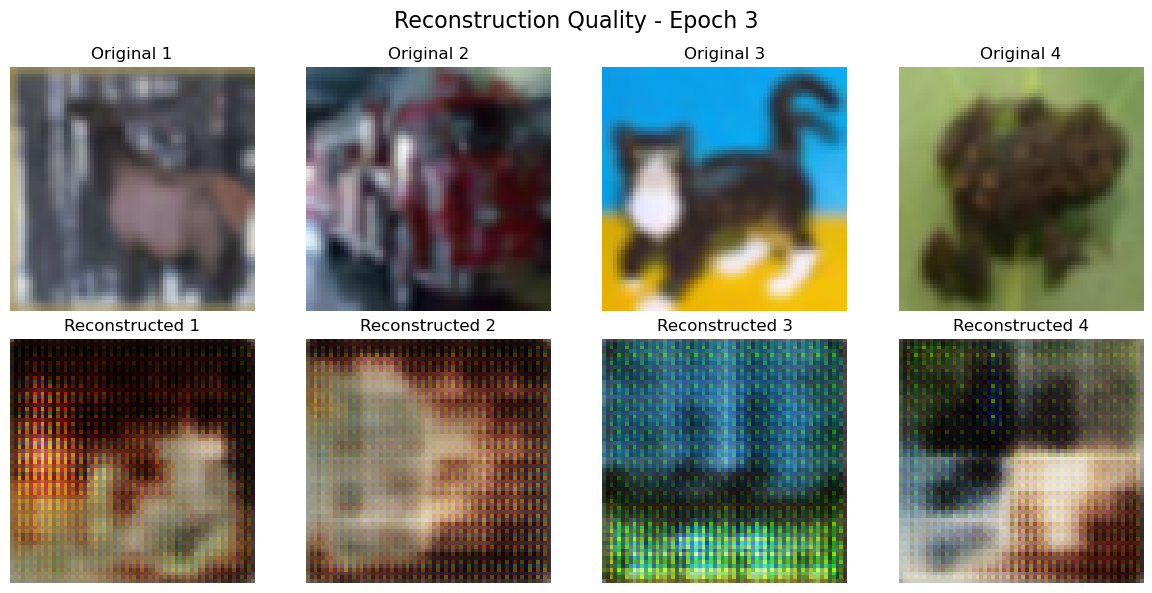

2025-08-10 21:48:03,373 - __main__.HybridTrainer - INFO - Epoch 4 Step 0: Generator_total_loss=5.4696 Reconstruction_loss=0.3902 Adversarial_loss=5.0583 Codebook_loss=0.2056 Commitment_loss=0.2056 W_dist=16.8674
2025-08-10 21:48:25,003 - __main__.HybridTrainer - INFO - Epoch 4 Step 100: Generator_total_loss=9.9780 Reconstruction_loss=0.4123 Adversarial_loss=9.5492 Codebook_loss=0.2144 Commitment_loss=0.2144 W_dist=10.1293
2025-08-10 21:48:45,374 - __main__.HybridTrainer - INFO - Epoch 4 Step 200: Generator_total_loss=13.2793 Reconstruction_loss=0.3781 Adversarial_loss=12.8981 Codebook_loss=0.1906 Commitment_loss=0.1906 W_dist=11.1719
2025-08-10 21:49:06,900 - __main__.HybridTrainer - INFO - Epoch 4 Step 300: Generator_total_loss=13.6634 Reconstruction_loss=0.3780 Adversarial_loss=13.3020 Codebook_loss=0.1807 Commitment_loss=0.1807 W_dist=13.5419
2025-08-10 21:49:27,844 - __main__.HybridTrainer - INFO - Epoch 4 Step 400: Generator_total_loss=5.5154 Reconstruction_loss=0.3125 Adversarial

In [ ]:
# Training Example with CIFAR10
logger.info("PREPARING CIFAR10 TRAINING EXAMPLE")
logger.info("="*80)

# Initialize dataset loader
dataset_loader = DataSetLoader(batch_size=64, data_dir='./data')

# Load CIFAR10 data
dataloader, num_batches, img_size, channels = dataset_loader.load_cifar10()

# Create hybrid model with dynamic architecture
model = HybridVQVAEWGAN(
    input_dim=channels,       # 3 for CIFAR10
    latent_dim=128,          # Latent dimension
    codebook_size=1024,      # Codebook size
    img_size=img_size        # [64, 64]
)

# Initialize trainer with enhanced settings
trainer = HybridTrainer(
    model=model,
    device=device,
    vqvae_lr=1e-3,           # VQVAE learning rate
    critic_lr=5e-5,          # Critic learning rate (lower for stability)
    lambda_gp=10,            # Gradient penalty coefficient
    critic_iters=1,          # Train critic 5x per generator step
    loss_weights={           # Loss component weights
        'reconstruction': 1.0,
        'adversarial': 1.0,
        'codebook': 1.0,
        'commitment': 1.0
    },
    use_weight_clipping=False,
    clip_value=0.01          
)

logger.info("STARTING TRAINING...")
logger.info("="*80)

# Train the model
trainer.train(dataloader, num_epochs=10, log_every=100, viz_every=1)

# Plot training history
trainer.plot_history()


2025-08-10 23:38:24,058 - HybridVQVAE_WGAN - INFO - 🎯 MNIST TRAINING EXAMPLE
2025-08-10 23:38:24,060 - HybridVQVAE_WGAN - INFO - ================================================================================
2025-08-10 23:38:24,061 - __main__.DataSetLoader - INFO - DataSetLoader initialized | batch_size=64 | data_dir=./data
2025-08-10 23:38:24,062 - __main__.DataSetLoader - INFO - 🔄 Loading MNIST dataset...
2025-08-10 23:38:24,134 - __main__.DataSetLoader - INFO - MNIST loaded | Dataset=mnist | batches=937 | img_size=[64, 64] | channels=1
2025-08-10 23:38:24,144 - __main__.VectorQuantizer - INFO - VectorQuantizer | codebook_size=512 | embedding_dim=64
2025-08-10 23:38:24,153 - __main__.VQVAE - INFO - DynamicVQVAE Architecture:
2025-08-10 23:38:24,153 - __main__.VQVAE - INFO -    Input: 1 channels, [64, 64]
2025-08-10 23:38:24,153 - __main__.VQVAE - INFO -    Latent: 64 dimensions
2025-08-10 23:38:24,154 - __main__.VQVAE - INFO -    Codebook: 512 entries
2025-08-10 23:38:24,154 - __ma

2025-08-10 23:38:24,167 - __main__.WGANCritic - INFO - DynamicWGANCritic Architecture:
2025-08-10 23:38:24,168 - __main__.WGANCritic - INFO -    Input: 1 channels, [64, 64]
2025-08-10 23:38:24,168 - __main__.WGANCritic - INFO -    Base channels: 32
2025-08-10 23:38:24,168 - __main__.WGANCritic - INFO -    Final spatial: 4x4
2025-08-10 23:38:24,169 - __main__.WGANCritic - INFO -    Total params: 693,632
2025-08-10 23:38:24,169 - __main__.HybridVQVAEWGAN - INFO - HybridVQVAEWGAN initialized:
2025-08-10 23:38:24,170 - __main__.HybridVQVAEWGAN - INFO -    Input dimensions: 1
2025-08-10 23:38:24,170 - __main__.HybridVQVAEWGAN - INFO -    Latent dimensions: 64
2025-08-10 23:38:24,170 - __main__.HybridVQVAEWGAN - INFO -    Codebook size: 512
2025-08-10 23:38:24,170 - __main__.HybridVQVAEWGAN - INFO -    Image size: [64, 64]
2025-08-10 23:38:24,171 - __main__.HybridVQVAEWGAN - INFO -    Total parameters: 1,318,785
2025-08-10 23:38:24,171 - __main__.HybridVQVAEWGAN - INFO -    VQVAE parameters:

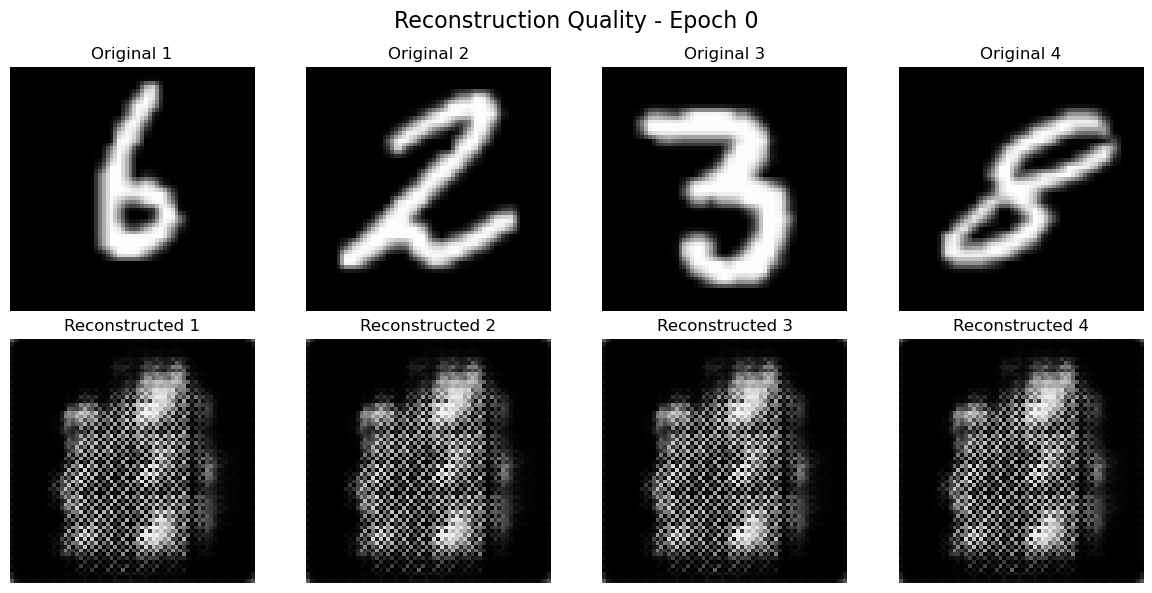

2025-08-10 23:39:56,797 - __main__.HybridTrainer - INFO - Epoch 1 Step 0: Generator_total_loss=167.9330 Reconstruction_loss=0.3722 Adversarial_loss=166.8959 Codebook_loss=0.5185 Commitment_loss=0.5185 W_dist=346.8237
2025-08-10 23:40:06,806 - __main__.HybridTrainer - INFO - Epoch 1 Step 100: Generator_total_loss=202.5094 Reconstruction_loss=0.4172 Adversarial_loss=201.4689 Codebook_loss=0.5202 Commitment_loss=0.5202 W_dist=418.2443
2025-08-10 23:40:16,558 - __main__.HybridTrainer - INFO - Epoch 1 Step 200: Generator_total_loss=229.9357 Reconstruction_loss=0.8959 Adversarial_loss=228.8729 Codebook_loss=0.5314 Commitment_loss=0.5314 W_dist=476.6422
2025-08-10 23:40:25,424 - __main__.HybridTrainer - INFO - Epoch 1 Step 300: Generator_total_loss=270.3109 Reconstruction_loss=1.5455 Adversarial_loss=269.3853 Codebook_loss=0.4628 Commitment_loss=0.4628 W_dist=553.8234
2025-08-10 23:40:35,420 - __main__.HybridTrainer - INFO - Epoch 1 Step 400: Generator_total_loss=299.3646 Reconstruction_loss=

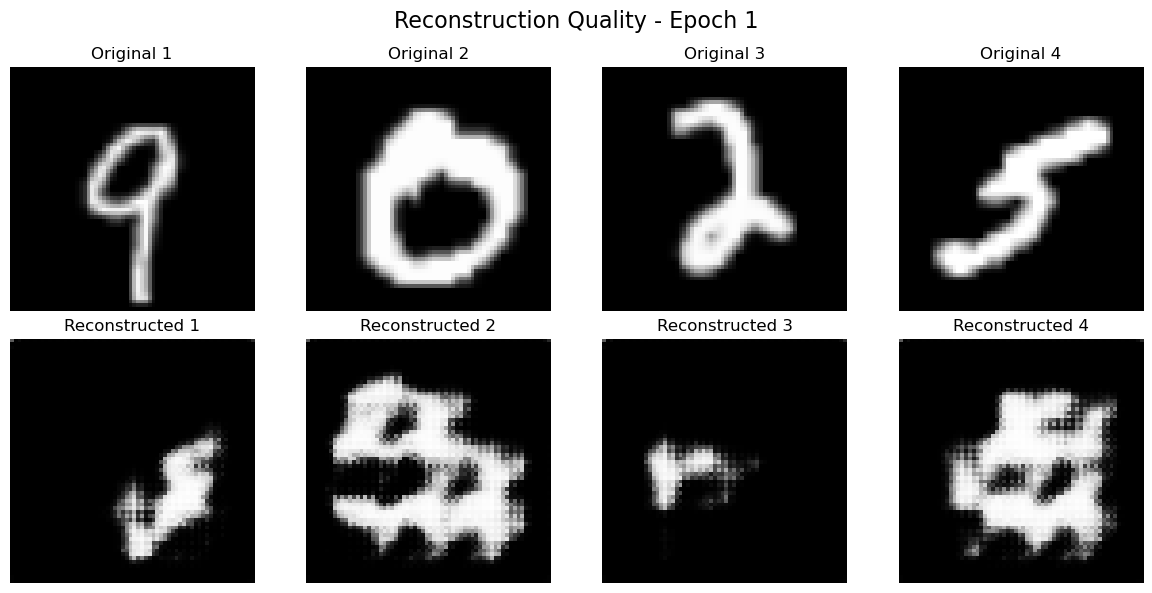

2025-08-10 23:41:27,679 - __main__.HybridTrainer - INFO - Epoch 2 Step 0: Generator_total_loss=353.7931 Reconstruction_loss=0.5862 Adversarial_loss=352.4147 Codebook_loss=0.6892 Commitment_loss=0.6892 W_dist=690.8916
2025-08-10 23:41:37,604 - __main__.HybridTrainer - INFO - Epoch 2 Step 100: Generator_total_loss=388.8834 Reconstruction_loss=0.4490 Adversarial_loss=387.7586 Codebook_loss=0.5624 Commitment_loss=0.5624 W_dist=743.3389
2025-08-10 23:41:47,337 - __main__.HybridTrainer - INFO - Epoch 2 Step 200: Generator_total_loss=359.3575 Reconstruction_loss=0.4810 Adversarial_loss=357.8109 Codebook_loss=0.7733 Commitment_loss=0.7733 W_dist=701.6052
2025-08-10 23:41:57,220 - __main__.HybridTrainer - INFO - Epoch 2 Step 300: Generator_total_loss=371.7717 Reconstruction_loss=0.4519 Adversarial_loss=370.3182 Codebook_loss=0.7267 Commitment_loss=0.7267 W_dist=686.8780
2025-08-10 23:42:05,857 - __main__.HybridTrainer - INFO - Epoch 2 Step 400: Generator_total_loss=461.6503 Reconstruction_loss=

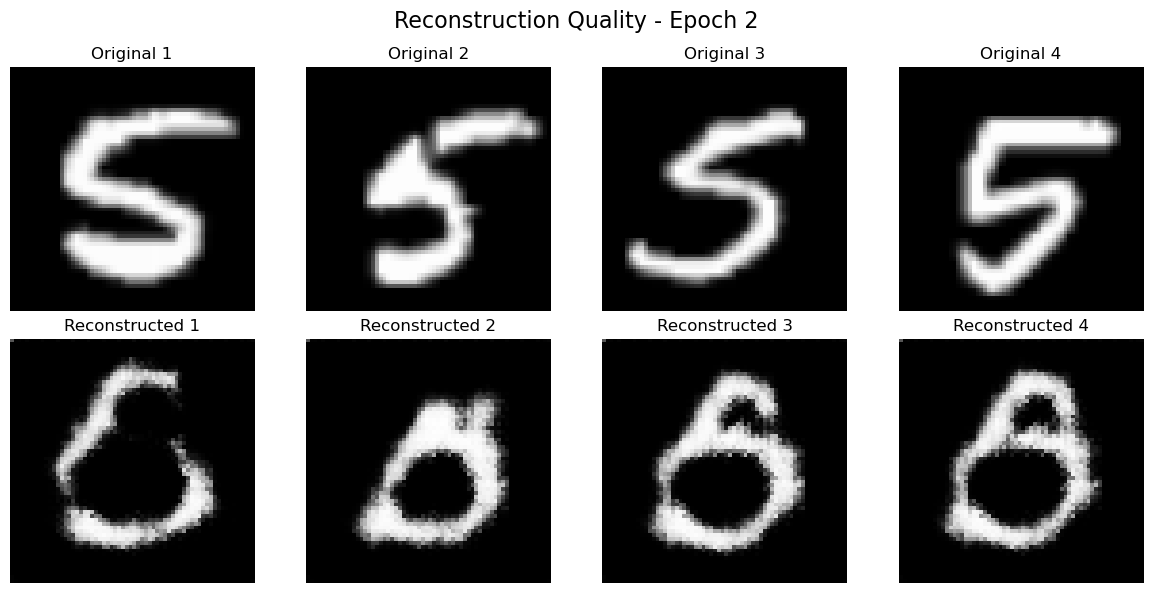

2025-08-10 23:42:58,408 - __main__.HybridTrainer - INFO - Epoch 3 Step 0: Generator_total_loss=392.5381 Reconstruction_loss=0.4030 Adversarial_loss=391.1772 Codebook_loss=0.6804 Commitment_loss=0.6804 W_dist=831.0551
2025-08-10 23:43:05,543 - __main__.HybridTrainer - INFO - Epoch 3 Step 100: Generator_total_loss=94.9479 Reconstruction_loss=0.4270 Adversarial_loss=93.5743 Codebook_loss=0.6868 Commitment_loss=0.6868 W_dist=702.8430
2025-08-10 23:43:12,391 - __main__.HybridTrainer - INFO - Epoch 3 Step 200: Generator_total_loss=235.6519 Reconstruction_loss=0.4392 Adversarial_loss=234.3799 Codebook_loss=0.6360 Commitment_loss=0.6360 W_dist=696.8788
2025-08-10 23:43:19,189 - __main__.HybridTrainer - INFO - Epoch 3 Step 300: Generator_total_loss=296.1160 Reconstruction_loss=0.4073 Adversarial_loss=294.8969 Codebook_loss=0.6096 Commitment_loss=0.6096 W_dist=652.7261
2025-08-10 23:43:26,050 - __main__.HybridTrainer - INFO - Epoch 3 Step 400: Generator_total_loss=231.8480 Reconstruction_loss=0.

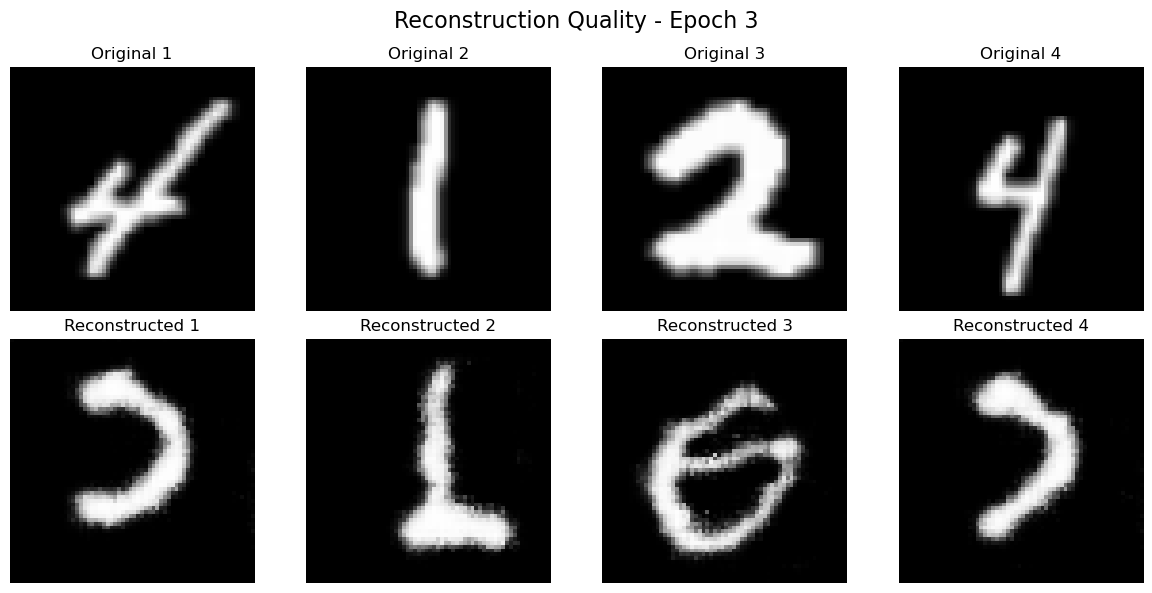

2025-08-10 23:44:02,811 - __main__.HybridTrainer - INFO - Epoch 4 Step 0: Generator_total_loss=279.5179 Reconstruction_loss=0.4278 Adversarial_loss=278.1413 Codebook_loss=0.6883 Commitment_loss=0.6883 W_dist=862.6152
2025-08-10 23:44:09,555 - __main__.HybridTrainer - INFO - Epoch 4 Step 100: Generator_total_loss=811.5844 Reconstruction_loss=0.4050 Adversarial_loss=810.1683 Codebook_loss=0.7080 Commitment_loss=0.7080 W_dist=683.3528
2025-08-10 23:44:16,314 - __main__.HybridTrainer - INFO - Epoch 4 Step 200: Generator_total_loss=199.0402 Reconstruction_loss=0.4727 Adversarial_loss=197.6077 Codebook_loss=0.7163 Commitment_loss=0.7163 W_dist=870.5678
2025-08-10 23:44:23,118 - __main__.HybridTrainer - INFO - Epoch 4 Step 300: Generator_total_loss=179.5452 Reconstruction_loss=0.4412 Adversarial_loss=178.1071 Codebook_loss=0.7190 Commitment_loss=0.7190 W_dist=978.0913
2025-08-10 23:44:32,327 - __main__.HybridTrainer - INFO - Epoch 4 Step 400: Generator_total_loss=385.8478 Reconstruction_loss=

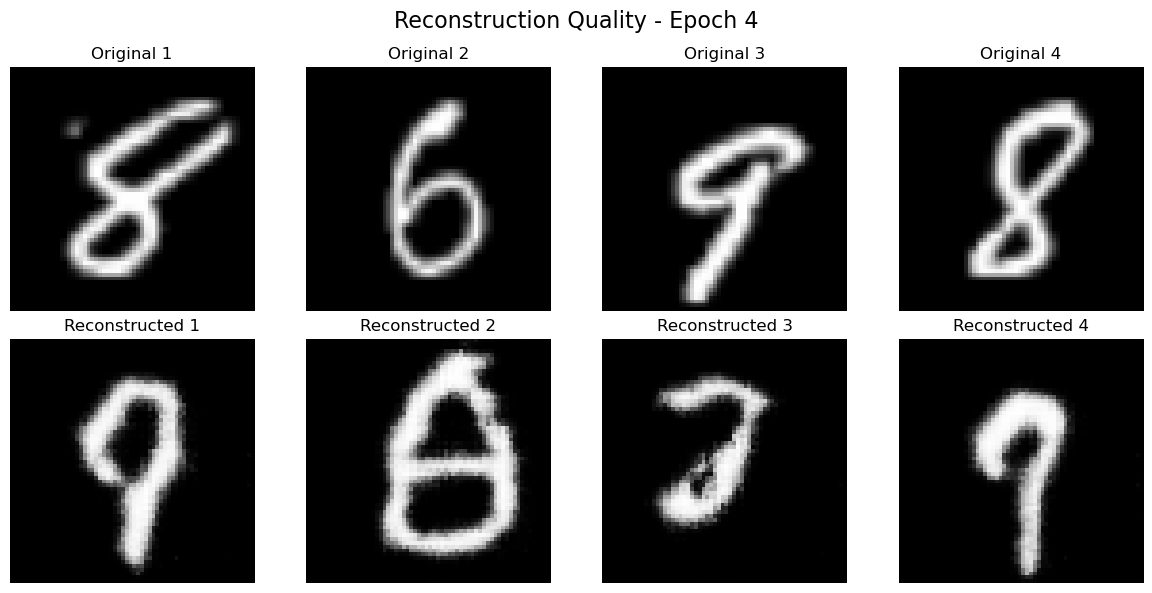

2025-08-10 23:45:25,108 - __main__.HybridTrainer - INFO - Epoch 5 Step 0: Generator_total_loss=966.7396 Reconstruction_loss=0.4645 Adversarial_loss=965.1262 Codebook_loss=0.8067 Commitment_loss=0.8067 W_dist=1059.3254
2025-08-10 23:45:34,774 - __main__.HybridTrainer - INFO - Epoch 5 Step 100: Generator_total_loss=101.2743 Reconstruction_loss=0.4374 Adversarial_loss=99.6251 Codebook_loss=0.8246 Commitment_loss=0.8246 W_dist=1251.9235
2025-08-10 23:45:44,539 - __main__.HybridTrainer - INFO - Epoch 5 Step 200: Generator_total_loss=3.9544 Reconstruction_loss=0.4699 Adversarial_loss=2.1975 Codebook_loss=0.8785 Commitment_loss=0.8785 W_dist=1169.2762
2025-08-10 23:45:54,469 - __main__.HybridTrainer - INFO - Epoch 5 Step 300: Generator_total_loss=1176.7461 Reconstruction_loss=0.4772 Adversarial_loss=1175.0332 Codebook_loss=0.8564 Commitment_loss=0.8564 W_dist=1151.7455
2025-08-10 23:46:04,440 - __main__.HybridTrainer - INFO - Epoch 5 Step 400: Generator_total_loss=982.9862 Reconstruction_loss

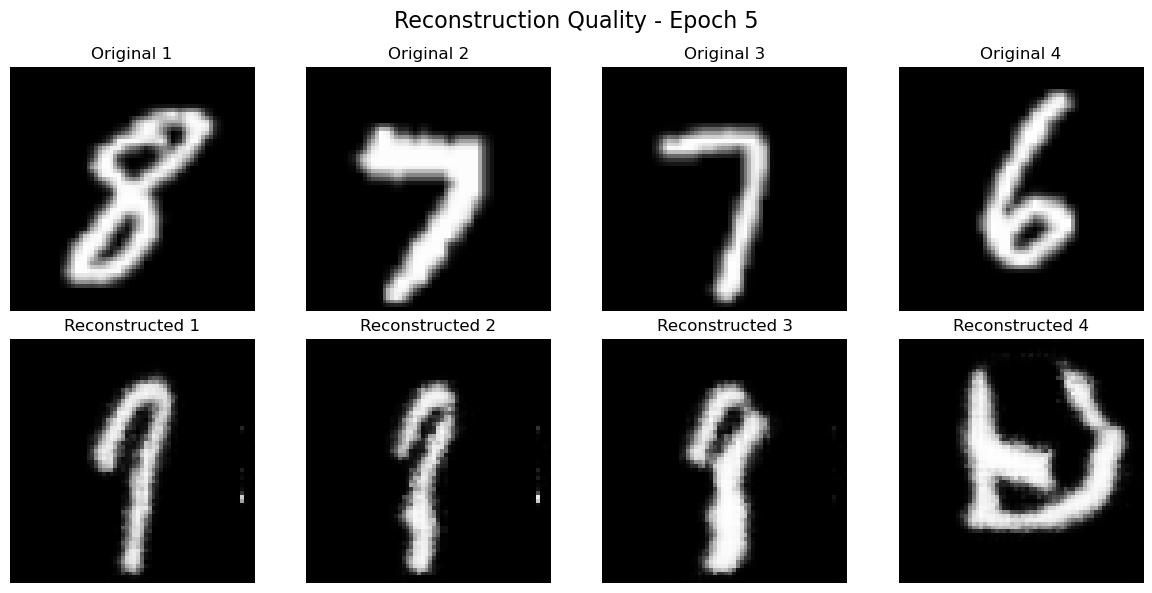

2025-08-10 23:46:57,260 - __main__.HybridTrainer - INFO - Epoch 6 Step 0: Generator_total_loss=1274.7534 Reconstruction_loss=0.4256 Adversarial_loss=1273.0132 Codebook_loss=0.8701 Commitment_loss=0.8701 W_dist=1655.2814
2025-08-10 23:47:07,119 - __main__.HybridTrainer - INFO - Epoch 6 Step 100: Generator_total_loss=1174.0044 Reconstruction_loss=0.4455 Adversarial_loss=1172.1638 Codebook_loss=0.9202 Commitment_loss=0.9202 W_dist=1540.2408
2025-08-10 23:47:15,974 - __main__.HybridTrainer - INFO - Epoch 6 Step 200: Generator_total_loss=1230.8954 Reconstruction_loss=0.4481 Adversarial_loss=1229.1366 Codebook_loss=0.8793 Commitment_loss=0.8793 W_dist=1666.6794
2025-08-10 23:47:25,935 - __main__.HybridTrainer - INFO - Epoch 6 Step 300: Generator_total_loss=1309.2390 Reconstruction_loss=0.4133 Adversarial_loss=1307.4973 Codebook_loss=0.8709 Commitment_loss=0.8709 W_dist=1716.4843
2025-08-10 23:47:35,867 - __main__.HybridTrainer - INFO - Epoch 6 Step 400: Generator_total_loss=-563.4539 Reconst

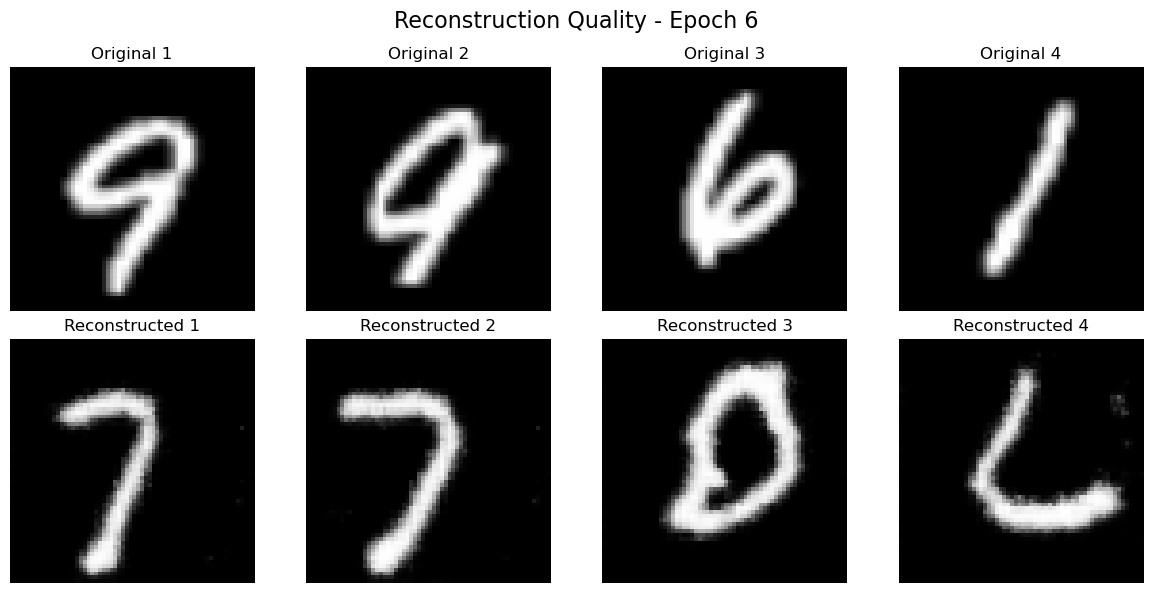

2025-08-10 23:48:28,731 - __main__.HybridTrainer - INFO - Epoch 7 Step 0: Generator_total_loss=1610.9254 Reconstruction_loss=0.4279 Adversarial_loss=1609.1544 Codebook_loss=0.8855 Commitment_loss=0.8855 W_dist=1907.2405
2025-08-10 23:48:38,569 - __main__.HybridTrainer - INFO - Epoch 7 Step 100: Generator_total_loss=1593.3551 Reconstruction_loss=0.4577 Adversarial_loss=1591.5348 Codebook_loss=0.9102 Commitment_loss=0.9102 W_dist=2143.0502
2025-08-10 23:48:48,315 - __main__.HybridTrainer - INFO - Epoch 7 Step 200: Generator_total_loss=466.7729 Reconstruction_loss=0.3948 Adversarial_loss=464.9874 Codebook_loss=0.8927 Commitment_loss=0.8927 W_dist=1917.2965
2025-08-10 23:48:58,154 - __main__.HybridTrainer - INFO - Epoch 7 Step 300: Generator_total_loss=1656.8235 Reconstruction_loss=0.4424 Adversarial_loss=1655.0771 Codebook_loss=0.8732 Commitment_loss=0.8732 W_dist=2075.3886
2025-08-10 23:49:07,142 - __main__.HybridTrainer - INFO - Epoch 7 Step 400: Generator_total_loss=1666.7844 Reconstru

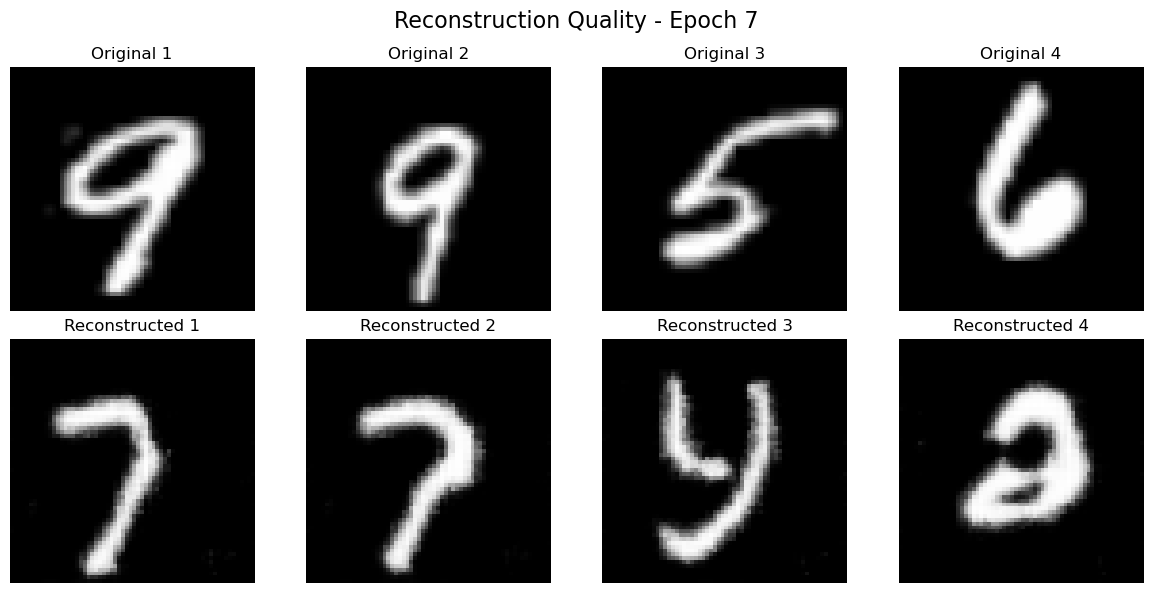

2025-08-10 23:50:00,650 - __main__.HybridTrainer - INFO - Epoch 8 Step 0: Generator_total_loss=1869.1743 Reconstruction_loss=0.4786 Adversarial_loss=1867.2595 Codebook_loss=0.9574 Commitment_loss=0.9574 W_dist=2000.1187
2025-08-10 23:50:09,717 - __main__.HybridTrainer - INFO - Epoch 8 Step 100: Generator_total_loss=1763.5050 Reconstruction_loss=0.4604 Adversarial_loss=1761.5526 Codebook_loss=0.9762 Commitment_loss=0.9762 W_dist=1882.1999
2025-08-10 23:50:19,524 - __main__.HybridTrainer - INFO - Epoch 8 Step 200: Generator_total_loss=1440.1887 Reconstruction_loss=0.4193 Adversarial_loss=1438.2197 Codebook_loss=0.9845 Commitment_loss=0.9845 W_dist=2131.1631
2025-08-10 23:50:29,279 - __main__.HybridTrainer - INFO - Epoch 8 Step 300: Generator_total_loss=1513.6674 Reconstruction_loss=0.4407 Adversarial_loss=1511.6840 Codebook_loss=0.9917 Commitment_loss=0.9917 W_dist=2609.2418
2025-08-10 23:50:39,159 - __main__.HybridTrainer - INFO - Epoch 8 Step 400: Generator_total_loss=388.5360 Reconstr

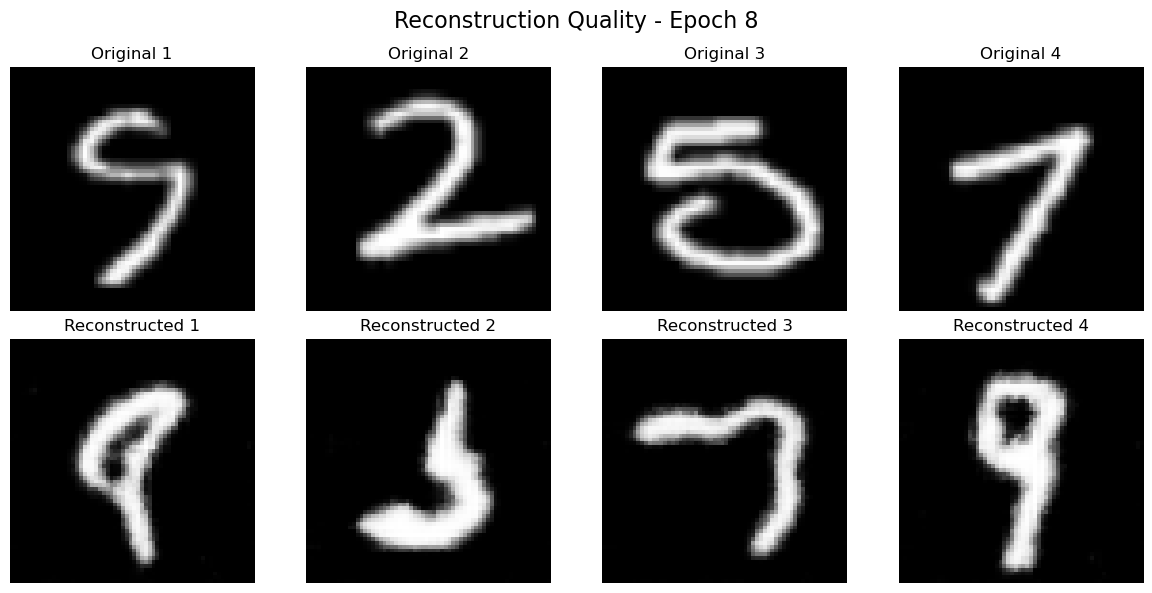

2025-08-10 23:51:31,822 - __main__.HybridTrainer - INFO - Epoch 9 Step 0: Generator_total_loss=2184.3535 Reconstruction_loss=0.4427 Adversarial_loss=2182.3003 Codebook_loss=1.0267 Commitment_loss=1.0267 W_dist=2898.1191
2025-08-10 23:51:41,647 - __main__.HybridTrainer - INFO - Epoch 9 Step 100: Generator_total_loss=2400.5737 Reconstruction_loss=0.4247 Adversarial_loss=2398.4824 Codebook_loss=1.0456 Commitment_loss=1.0456 W_dist=2815.5520
2025-08-10 23:51:51,520 - __main__.HybridTrainer - INFO - Epoch 9 Step 200: Generator_total_loss=1782.1293 Reconstruction_loss=0.4249 Adversarial_loss=1780.0084 Codebook_loss=1.0604 Commitment_loss=1.0604 W_dist=3146.0273
2025-08-10 23:52:00,376 - __main__.HybridTrainer - INFO - Epoch 9 Step 300: Generator_total_loss=-272.6918 Reconstruction_loss=0.4379 Adversarial_loss=-274.7256 Codebook_loss=1.0169 Commitment_loss=1.0169 W_dist=2302.4262
2025-08-10 23:52:10,318 - __main__.HybridTrainer - INFO - Epoch 9 Step 400: Generator_total_loss=2175.5845 Reconst

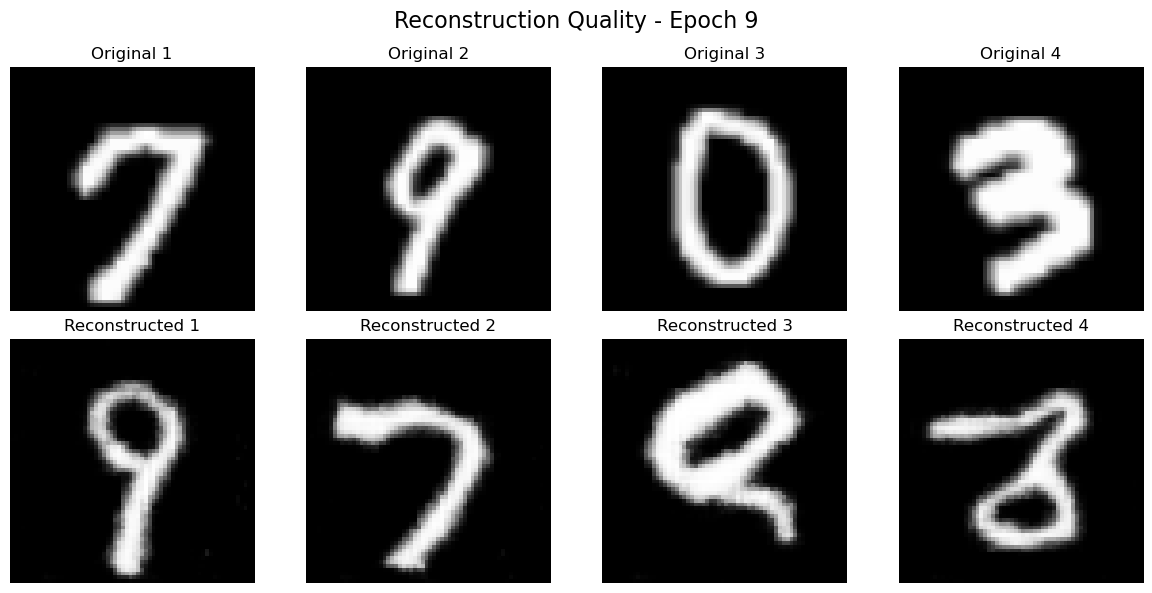

2025-08-10 23:53:02,444 - __main__.HybridTrainer - INFO - TRAINING COMPLETED in 14.6 minutes!
/tmp/ipykernel_3401223/2413477369.py:271: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sbeeredd/miniconda3/envs/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


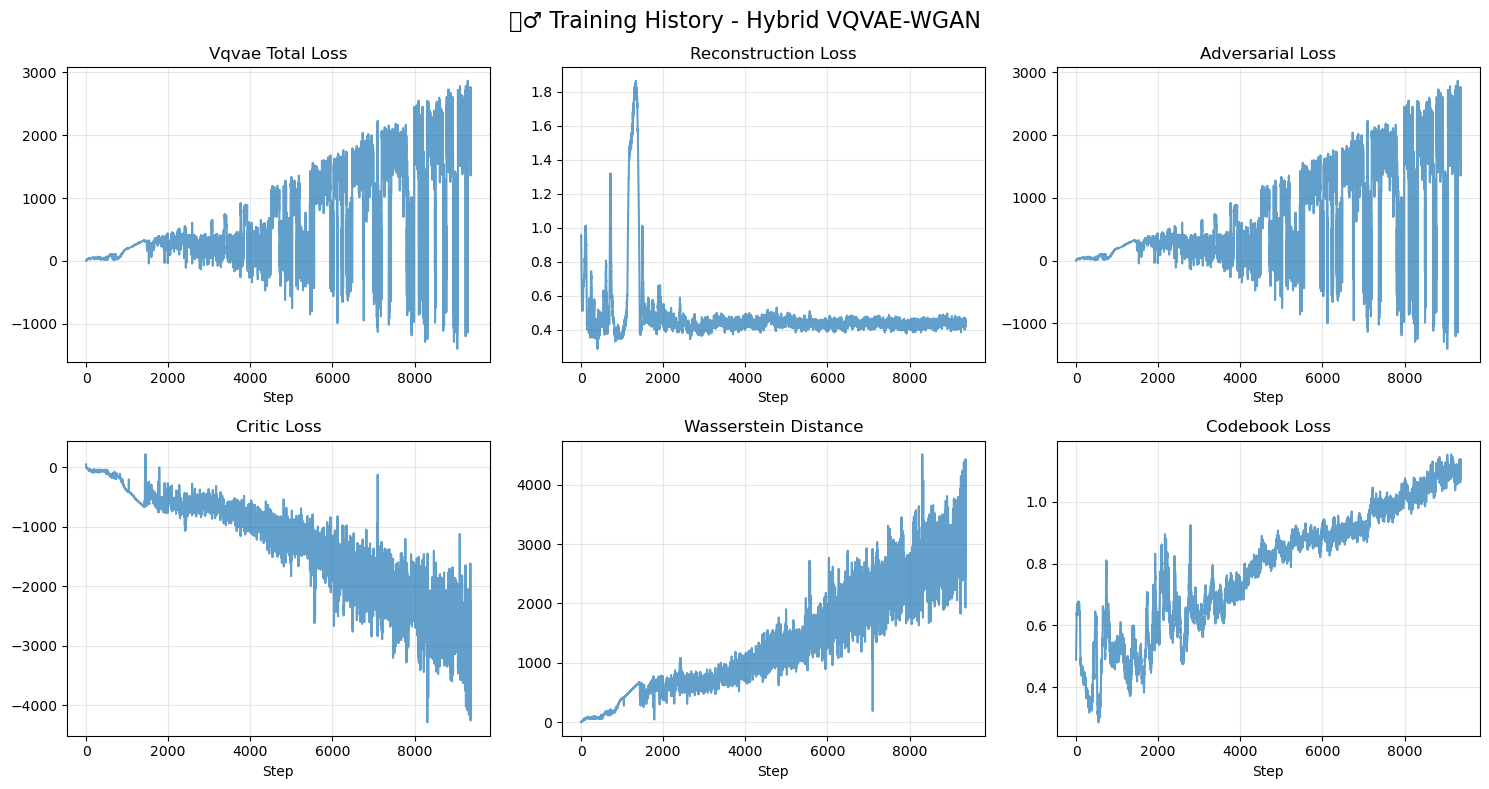

2025-08-10 23:53:03,185 - HybridVQVAE_WGAN - INFO - To train on MNIST, run:
2025-08-10 23:53:03,189 - HybridVQVAE_WGAN - INFO -    mnist_trainer.train(mnist_dataloader, num_epochs=10)


In [ ]:
# Additional Training Examples and Utilities

# Example with MNIST dataset
logger.info("🎯 MNIST TRAINING EXAMPLE")
logger.info("="*80)

dataset_loader = DataSetLoader(batch_size=100, data_dir='./data')

# Load MNIST data
mnist_dataloader, _, mnist_img_size, mnist_channels = dataset_loader.load_mnist()

# Create MNIST model
mnist_model = HybridVQVAEWGAN(
    input_dim=mnist_channels,    # 1 for MNIST
    latent_dim=64,              # Smaller latent for MNIST
    codebook_size=512,          # Smaller codebook for MNIST
    img_size=mnist_img_size
)

# MNIST trainer
mnist_trainer = HybridTrainer(
    model=mnist_model,
    device=device,
    vqvae_lr=1e-2,
    critic_lr=5e-6,
    critic_iters=1              # Fewer critic iterations for MNIST
)

mnist_trainer.train(mnist_dataloader, num_epochs=10)

mnist_trainer.plot_history()


logger.info("To train on MNIST, run:")
logger.info("   mnist_trainer.train(mnist_dataloader, num_epochs=10)")

# Utility functions
def compare_reconstructions(model, dataloader, num_samples=8):
    model.eval()
    
    # Get a batch
    for batch in dataloader:
        real_images, _ = batch
        break
    
    real_images = real_images[:num_samples].to(device)
    
    with torch.no_grad():
        reconstructed = model.reconstruct(real_images)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 4))
    
    for i in range(num_samples):
        # Original
        if real_images.shape[1] == 1:  # Grayscale
            axes[0, i].imshow(real_images[i, 0].cpu(), cmap='gray', vmin=-1, vmax=1)
        else:  # RGB
            img = real_images[i].cpu().permute(1, 2, 0)
            img = (img + 1) / 2
            axes[0, i].imshow(torch.clamp(img, 0, 1))
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # Reconstructed
        if reconstructed.shape[1] == 1:  # Grayscale
            axes[1, i].imshow(reconstructed[i, 0].cpu(), cmap='gray', vmin=-1, vmax=1)
        else:  # RGB
            img = reconstructed[i].cpu().permute(1, 2, 0)
            img = (img + 1) / 2
            axes[1, i].imshow(torch.clamp(img, 0, 1))
        axes[1, i].set_title(f'Reconstructed {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    model.train()

def analyze_codebook_usage(model, dataloader, num_batches=10):
    """Analyze codebook usage statistics"""
    model.eval()
    codebook_usage = torch.zeros(model.codebook_size)
    
    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i >= num_batches:
                break
            
            images = images.to(device)
            z_e = model.encode(images)
            
            # Get quantization indices (simplified)
            flat_input = z_e.view(-1, model.latent_dim)
            distances = torch.sum(flat_input**2, dim=1, keepdim=True) + torch.sum(model.vqvae.quantizer.embeddings.weight**2, dim=1) - 2 * torch.matmul(flat_input, model.vqvae.quantizer.embeddings.weight.t())
            indices = torch.argmin(distances, dim=1)
            
            # Count usage
            for idx in indices:
                codebook_usage[idx] += 1
    
    model.train()
    
    # Plot usage distribution
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(codebook_usage)), codebook_usage.cpu())
    plt.title('Codebook Usage Distribution')
    plt.xlabel('Codebook Index')
    plt.ylabel('Usage Count')
    plt.show()
    
    used_entries = (codebook_usage > 0).sum().item()
    logger.info(f"Codebook Analysis:")
    logger.info(f"Total entries: {len(codebook_usage)}")
    logger.info(f"Used entries: {used_entries}")
    logger.info(f"Usage rate: {used_entries/len(codebook_usage)*100:.1f}%")
